- This notebook allows to constrain the 3D morphology of galaxies from their 2D projected images
- Method : simulation-based inference
- Data : shape catalogue of UNIONS matched with the CMASS density tracers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch

from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [589]:
# CMASS density tracers

cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/galaxy_DR12v5_CMASS_North.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass = filtered_tbl.to_pandas()
cmass.columns

print(len(cmass))

618806


In [590]:
# UNIONS shape catalogues

unions = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_shapepipe_v1.3.1.fits')
names = [name for name in unions.colnames if len(unions[name].shape) <= 1]
filtered_tbl = unions[names]
unions = filtered_tbl.to_pandas()
print(len(unions))

83812739


In [591]:
# Match between UNIONS and CMASS

cat_unions = SkyCoord(ra= unions['RA'], dec=unions['Dec'],unit='deg')
cat_cmass = SkyCoord(ra=cmass['RA'] , dec=cmass['DEC'] , unit='deg')
idx, d2d, d3d = match_coordinates_sky(cat_unions, cat_cmass)
unions_cmass_cross = unions.loc[d2d.value < 0.00010]

print(len(unions_cmass_cross))

nb_unions_cmass = len(unions_cmass_cross)

unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)

74978


In [592]:
# Somes functions required for further work

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

In [593]:
# DATA

a = np.zeros(len(unions_cmass_cross)) ; b = np.zeros(len(unions_cmass_cross)); theta = np.zeros(len(unions_cmass_cross))
axis_ratio_cmass = np.zeros(len(unions_cmass_cross))
e1cmass = np.zeros(len(unions_cmass_cross)) ; e2cmass = np.zeros(len(unions_cmass_cross)) ; ecmass = np.zeros(len(unions_cmass_cross))

for i in range (len(unions_cmass_cross)):
    a[i],b[i] = a_b(unions_cmass_cross['e1'][unions_cmass_index[i]],unions_cmass_cross['e2'][unions_cmass_index[i]])
    axis_ratio_cmass[i] = a[i]/b[i]
    theta[i] = get_galaxy_orientation_angle(unions_cmass_cross['e1'][unions_cmass_index[i]],unions_cmass_cross['e2'][unions_cmass_index[i]])
    e1cmass[i],e2cmass[i] = e_complex(a[i],b[i],theta[i])
    ecmass[i] = abs_e(e1cmass[i],e2cmass[i])

In [595]:
# SIMULATION : function that returns the normalized projected ellipticities (2D information) of the nb_unions_cmass 3D galaxies of the 
# simulated survey. The projection is done along the line-of-sight (LOS, direction 'y'). 

# References : 
    # (1) Lamman et al., https://arxiv.org/pdf/2209.03949
    # (2) From Gendzwill D. J., Stauffer M. R., 1981, https://www.researchgate.net/profile/D-Gendzwill/publication/225869829_Analysis_of_triaxial_ellipsoids_Their_shapes_plane_sections_and_plane_projections/links/5aa18aa2a6fdcc22e2d11fc5/Analysis-of-triaxial-ellipsoids-Their-shapes-plane-sections-and-plane-projections.pdf

def simulation(theta, # The parameters of the 3D model (mu_B, mu_C, sigma_B, sigma_C, r)
               nb_galaxies=nb_unions_cmass, # The number of matched galaxies
               p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
               A=1, # The major axis of the galaxies, fixed to 1 in the analysis
               e_bins=np.linspace(0,1,50) # The number of bins for the histogram of e_counts (output)
               ):

    mu_B, mu_C, sigma_B, sigma_C, r = theta

    # Random gaussian draw to obtain the axis lengths B,C
    BC = np.random.multivariate_normal(mean=[mu_B, mu_C], cov=[[sigma_B**2, r*sigma_B*sigma_C], [r*sigma_B*sigma_C, sigma_C**2]], size=nb_galaxies)
    
    
    # Priors : B/A<1 ; C/A<1 ; C<B ; C>0 ; B>0
    mask = (BC[:,0]/A<=1) & (BC[:,1]/ A<=1) & (BC[:,0] >= BC[:,1]) & (BC[:,0]>0) & (BC[:,1]>0)
    BC2 = BC[mask]
    B=BC2[:,0] ; C=BC2[:,1]

    A=np.ones(len(BC2)) 

    nb_galaxies=len(BC2)


    # Random orientation angles by drawing quaternions (to have orientations uniformly distributed in the sky)
    if nb_galaxies > 0:
        rand_quat = np.random.randn(nb_galaxies,4) ; rand_quat /= np.linalg.norm(rand_quat, axis=1, keepdims=True)
        rotation = Rotation.from_quat(rand_quat) ; euler_angles = rotation.as_euler('ZYX', degrees=True)
        euler_angles_rad = euler_angles*np.pi/180
        psi = euler_angles_rad[:,0]; theta = euler_angles_rad[:,1] ; phi = euler_angles_rad[:,2]
    else:
        return np.zeros_like(e_bins[:-1])
    

    # Rotation matrix that relates the eigenvectors (X,Y,Z) of the galaxies to a frame of reference (x,y,z)
    D = np.zeros((nb_galaxies, 3, 3))

    D[:, 0, 0] = np.cos(theta) * np.cos(psi)
    D[:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
    D[:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

    D[:, 1, 0] = np.cos(theta) * np.sin(psi)
    D[:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
    D[:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

    D[:, 2, 0] = -np.sin(theta)
    D[:, 2, 1] = np.sin(phi) * np.cos(theta)
    D[:, 2, 2] = np.cos(phi) * np.cos(theta)

    
    evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) # Frame of reference (x,y,z)
    evcl = np.einsum('ijk,kl->ijl', D, evc0) # Eigenvectors (X,Y,Z)


    #Eigenvalues (Maj,Mid,Min)
    evls = np.array([A,B,C])**2 ; evls=np.transpose(evls)


    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))

    # Projected ellipticity
    def e_complex(a,b,r):
        abs_e = (1-(b/a)) / (1+(b/a))
        e1 = abs_e*np.cos(2*r)
        e2 = abs_e*np.sin(2*r)
        return e1, e2

    e1, e2 = e_complex(a_p, b_p, r_p) ; e = [e1,e2] ; e=np.array(e)

    # Final output = summary statistics = P(e)
    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)
    
    return e_counts/nb_galaxies # Normalizing by the number of galaxies

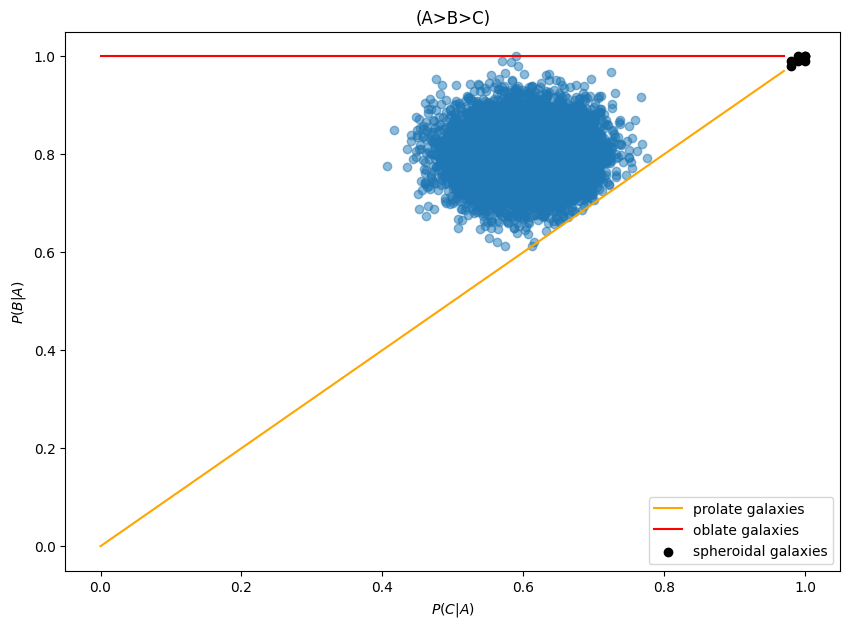

In [3]:
# Visualization of a population of ellipsoidal galaxies with axis lengths B,C (convention A=1>B>C)

A=1 ; nb_galaxies = 10000

# Model = {mu_B, mu_C, sigma_B, sigma_C}
mu_B=0.8; mu_C=0.6; sigma_B=0.05; sigma_C=0.05; r=0.01

BC = np.random.multivariate_normal(mean=[mu_B,mu_C],cov=[[sigma_B**2,r*sigma_B*sigma_C],[r*sigma_B*sigma_C,sigma_C**2]],size=nb_galaxies)


# remove B/A>1, C/A>1, C>B, B<0, C<0
# B => BC[0,0] ; C => BC[0,1]
BC2=[]
for i in range (len(BC)):
    if BC[i,0]/A<=1 and BC[i,1]/A<=1 and BC[i,0]>=BC[i,1] and BC[i,0]>0 and BC[i,1]>0:
        BC2.append([BC[i,0],BC[i,1]])
BC2=np.array(BC2)


plt.figure( figsize = (10,7) )
plt.scatter(BC2[:,1]/A,BC2[:,0]/A,alpha=0.5)
plt.xlabel(r"$P(C \vert A)$") ; plt.ylabel(r"$P(B \vert A)$")
plt.title("(A>B>C)")

x=np.linspace(0,0.97,30) ; y=x
plt.plot(x, y,color='orange',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([0.99,1,0.99,1,0.98,0.98,1],[0.99,1,1,0.99,0.98,0.99,1],color='black',label='spheroidal galaxies')
plt.legend()
plt.savefig("Population.pdf")

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/208390374.py:85: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/208390374.py:86: RuntimeWarning: invalid value encountered in sqrt
  b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


<Figure size 1000x700 with 0 Axes>

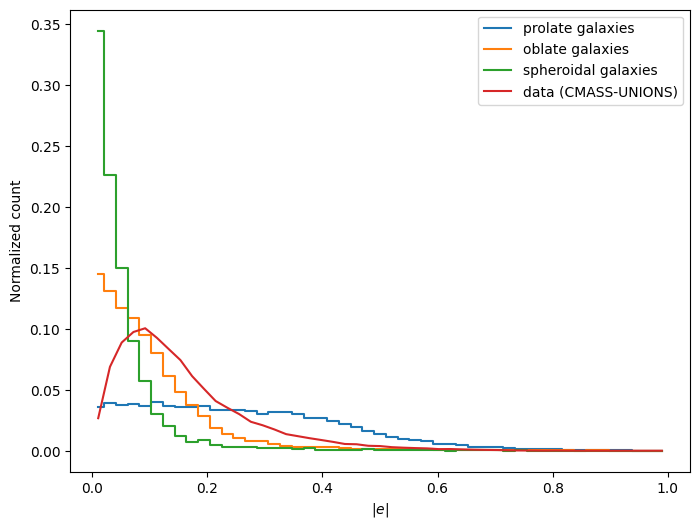

In [605]:
# View of simulations for differents shapes of 3D galaxies, and superposition with the data

x_estimated1 = simulation([0.4, 0.4, 0.1, 0.1, 0.01])
x_estimated2 = simulation([1, 0.8, 0.1, 0.1, 0.01])
x_estimated3 = simulation([1, 1, 0.1, 0.1, 0.01])

e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,x_estimated1,drawstyle='steps-mid',label='prolate galaxies')
plt.plot(e_cents,x_estimated2,drawstyle='steps-mid',label='oblate galaxies')
plt.plot(e_cents,x_estimated3,drawstyle='steps-mid',label='spheroidal galaxies')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")
plt.savefig("P(e).pdf")

In [598]:
# Priors on the input parameters

prior = BoxUniform(
    low=torch.tensor([0.3, 0.3, 0,   0,  -0.8]),
    high=torch.tensor([1,  1,   0.2, 0.2, 0.8])
)

In [ ]:
# Neural posterior estimation

posterior = infer(simulation, 
                             prior, 
                             method = 'NPE', 
                             num_simulations = 60000 , 
                             num_workers = 40 )

100%|██████████| 60000/60000 [09:59<00:00, 100.02it/s]


 Neural network successfully converged after 219 epochs.

(1, 49)


Drawing 30000 posterior samples: 30004it [00:00, 33038.52it/s]                           


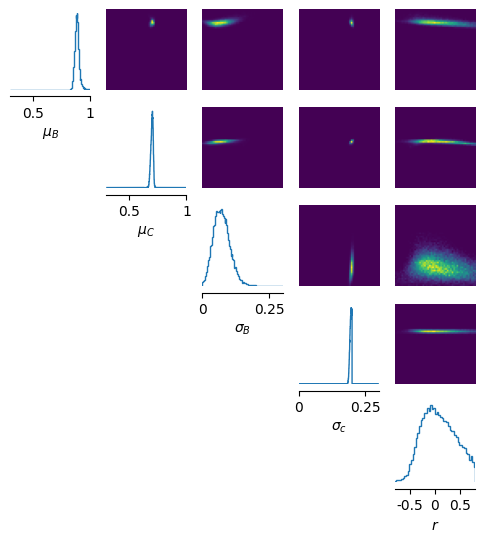

In [587]:
# Constraints on the 3D morphology of the galaxies

e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

e_counts_data = [e_data_counts] ; e_counts_data=np.array(e_counts_data)
print(e_counts_data.shape)

x_obs = e_counts_data/nb_unions_cmass

samples = posterior.sample((30000,), x=x_obs)

pairplot(samples,
             limits=[[0.3,1], [0.3,1], [0,0.3], [0,0.3], [-0.8,0.8]],
             figsize=(6, 6),
             labels=[r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_c$", r"$r$"],
             )

plt.savefig("3D_morphology.pdf")

[0.88317436 0.69943696 0.07090379 0.1948759  0.08082359]


Text(0, 0.5, 'Normalized count')

<Figure size 1000x700 with 0 Axes>

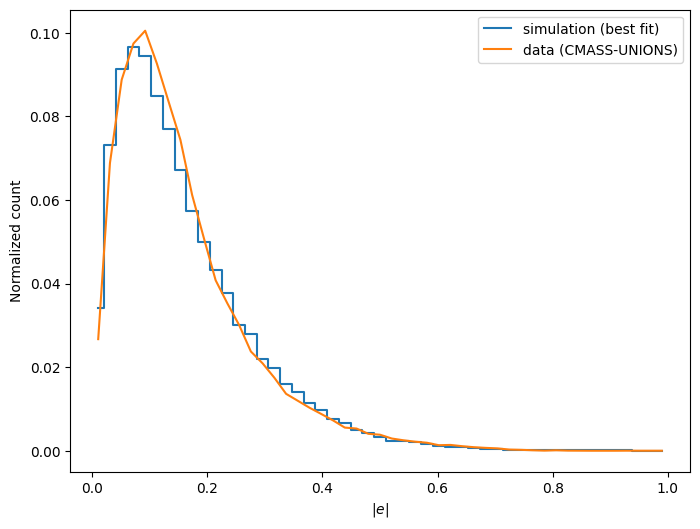

In [ ]:
# Best fit obtained after having performed the simulations

theta_estimated=np.mean(samples.numpy(), axis=0) ; print(theta_estimated)

mu_B, mu_C, sigma_B, sigma_C, r = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]

x_estimated = simulation([mu_B, mu_C, sigma_B, sigma_C, r])

plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,x_estimated,drawstyle='steps-mid',label='simulation (best fit)')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")
plt.savefig("cmass.pdf")

(<Figure size 600x600 with 25 Axes>,
 array([[<Axes: xlabel='$\\mu_B$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='$\\mu_C$'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='$\\sigma_B$'>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='$\\sigma_c$'>,
         <Axes: >],
        [<Axes: xlabel='$\\mu_B$'>, <Axes: xlabel='$\\mu_C$'>,
         <Axes: xlabel='$\\sigma_B$'>, <Axes: xlabel='$\\sigma_c$'>,
         <Axes: xlabel='$r$'>]], dtype=object))

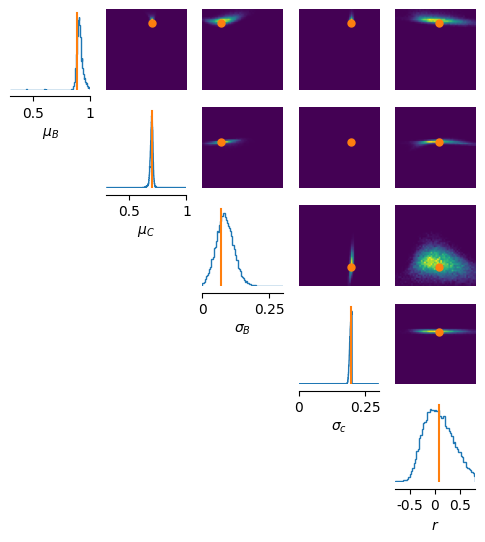

In [602]:
# Superposition between the contours and the best fit

pairplot(samples,
             points=theta_estimated,
             limits=[[0.3,1], [0.3,1], [0,0.3], [0,0.3], [-0.8,0.8]],
             figsize=(6, 6),
             labels=[r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_c$", r"$r$"],
             )